## Summative Lab ##
As a junior data scientist at a forestry management company, your role is to support efforts to reduce the damage caused by wildfires by identifying patterns in past fire occurrences and predicting areas at high risk. Wildfires are highly unpredictable and are influenced by a combination of environmental conditions, weather patterns, and geographic factors. The company relies on data-driven insights to allocate firefighting resources efficiently and implement preventive measures before fires escalate.

**Using the Forest Fires dataset, your primary objective is to:**

- Analyze the factors that contribute to fire size and severity.
- Develop models capable of predicting high-risk areas.
- Provide actionable recommendations to aid in risk mitigation.
This requires analyzing various environmental factors, such as temperature, humidity, wind speed, and precipitation, to determine which conditions are most critical in influencing wildfire behavior. Additionally, you must determine whether certain geographic factors, such as proximity to urban areas, vegetation density, or elevation, play a role in fire intensity and spread.

Your work will help forestry professionals and emergency response teams make informed decisions about where to deploy resources, when to issue alerts, and how to minimize destruction caused by wildfires.


Challenges for this Lab
- Data Understanding and Preprocessing: Analyzing the dataset structure, handling missing values or inconsistencies, and applying necessary transformations to prepare the data for modeling.
- Feature Selection and Engineering for Regression: Identifying the most relevant predictors, handling multicollinearity, and applying transformations or interactions to improve model performance.
- Model Selection and Performance Evaluation: Comparing multiple regression models based on statistical metrics, residual diagnostics, and model assumptions to determine the best fit.
- Applying Regularization for Improved Generalization: Using Ridge and Lasso regression to address overfitting and multicollinearity while interpreting the trade-offs between feature selection and regularization strength.
- Transitioning from Regression to Classification: Converting the target variable into a binary classification problem, training a logistic regression model, and evaluating its predictive performance.
- Final Model Interpretation and Decision-Making: Synthesizing findings from regression and classification models, comparing trade-offs, and recommending the best approach for predicting or classifying fire behavior.

**STEP 1**

- Install and import the ucimlrepo library.
- Load the Forest Fires dataset:
- Predictors: Features from forest_fires.data.features.
- Target: forest_fires.data.targets.


In [336]:
#STEP 1. Load the dataset

# Run pip install if necessary to access the UCI ML Repository
! pip install ucimlrepo


# Data
from ucimlrepo import fetch_ucirepo


forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets


# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

STEP 2. Exploratory Data Analysis EDA

- Examine the dataset structure and summary statistics.
- Analyze correlations between predictors and the target variable.
- Plot scatterplots for key predictors vs. the target.
- Generate a residual plot to check for randomness in residuals.



In [338]:

#Combine predictor and target for full view
df_fires = pd.concat([X, y], axis=1)

#Basic info
df_fires.info()

#Summary statistics
df_fires.describe()

#Display first few rows
df_fires.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


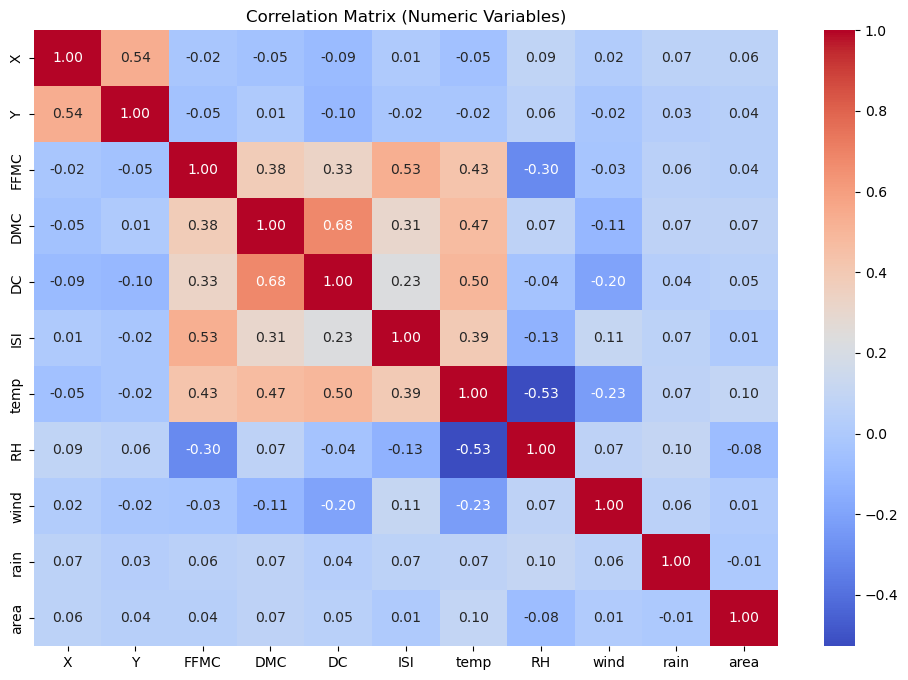

In [339]:
#Correlation heatmap excluding categorical variables for correlation analysis
#excluding month and day wich are stored as strings and causes error when trying to compute correlations or fit models
#Correlation heatmap is excellent to overview of wich variables are strongly related

df_fires_numeric = df_fires.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_fires_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numeric Variables)')
plt.show()

temp    0.097844
RH      0.075519
DMC     0.072994
Name: area, dtype: float64


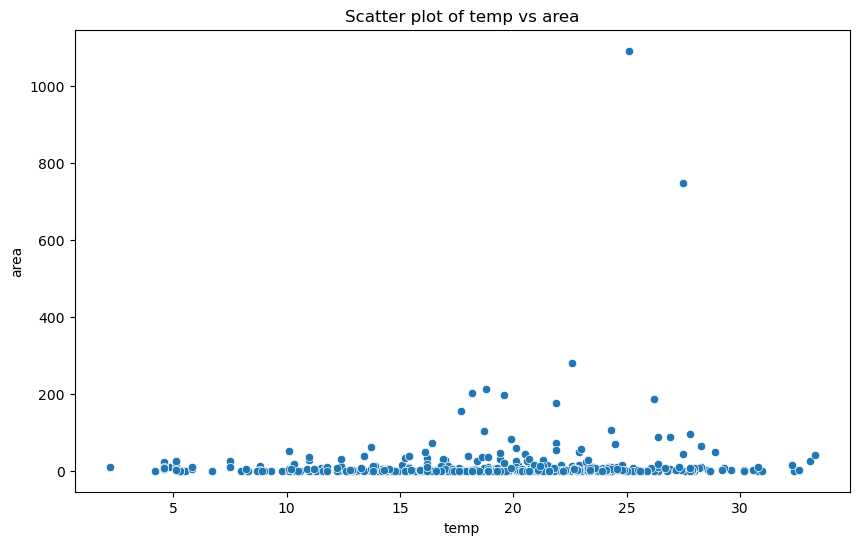

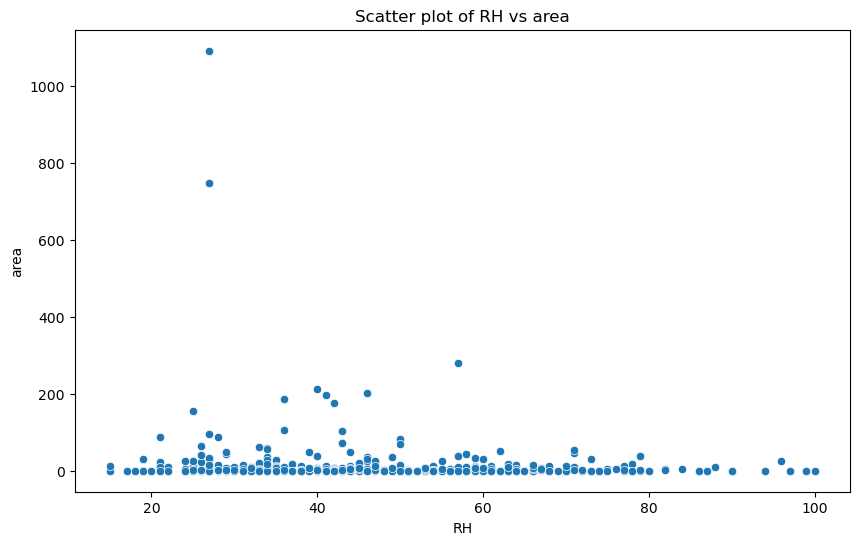

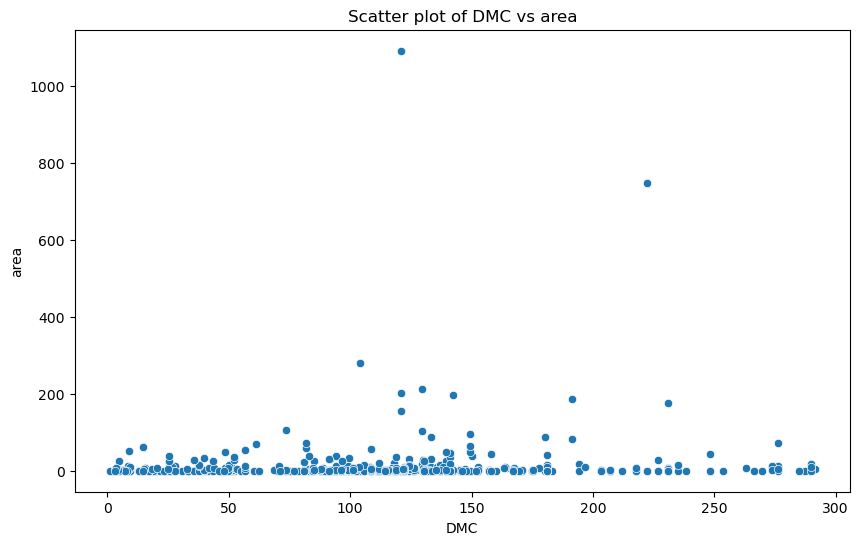

In [340]:
#Finding the predictor most correlated with area is important to understand what influences fire size and severity, predicting high risk areas,
#and provide insights for mitigation strategies.

#Scatter plot for key predictor variables
top_correlated = df_fires_numeric.corr()['area'].abs().sort_values (ascending=False)[1:4]

print (top_correlated)

for col in top_correlated.index:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_fires[col], y=df_fires_numeric['area'])
    plt.title(f'Scatter plot of {col} vs area')
    plt.xlabel(col)
    plt.ylabel('area')
    plt.show()
    

STEP 3. FIT REGRESSION MODELS

- Fit a baseline multiple linear regression model with key predictors.
- Include nonlinear terms (e.g., quadratic transformations for significant predictors).
- Add interaction terms (e.g., between predictors with strong correlations).
- Incorporate indicator variables if categorical variables are present.
- Apply transformations (e.g., logarithmic transformations for skewed predictors).



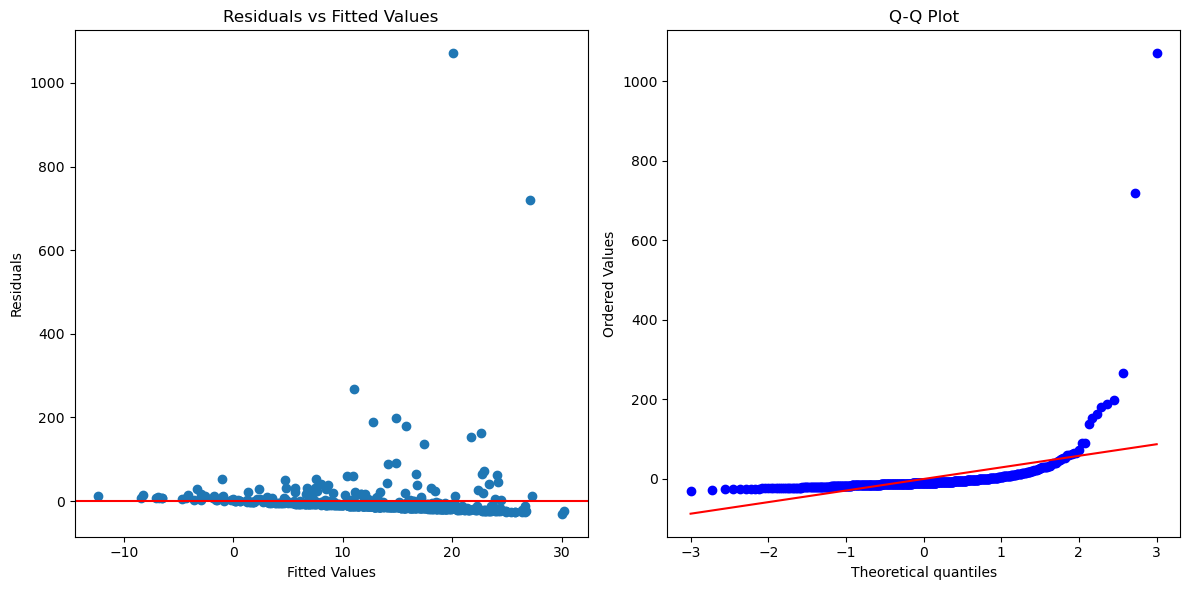

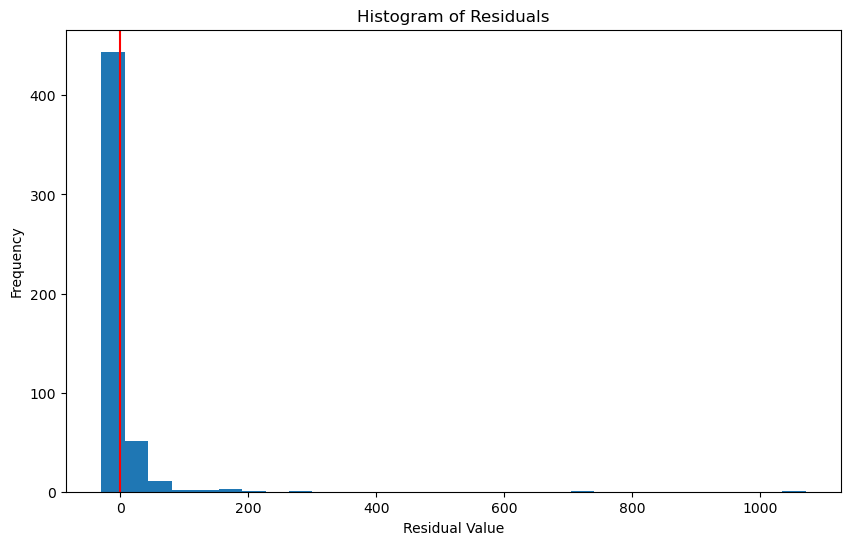

In [341]:
#Create features array with top correlated variables
features = top_correlated.index.tolist()
X = df_fires[features]
y = df_fires_numeric['area']

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Create residual plots
plt.figure(figsize=(12, 6))

# Plot 1: Residuals vs Fitted values
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# Plot 2: QQ Plot to check for normality of residuals
plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Additional residual plot: histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r')
plt.show()

In [342]:

# Log-transform area due to right-skew as per the description in forestfires.names
#area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make 
#sense to model with the logarithm transform). 

df_fires['log_area'] = np.log1p(df_fires['area'])  # log(1 + area) to handle 0s

# Use this for correlation
correlations = df_fires.corr(numeric_only=True)['log_area'].sort_values(ascending=False)
print(correlations)

log_area    1.000000
area        0.524134
DMC         0.067153
wind        0.066973
DC          0.066360
X           0.061995
temp        0.053487
FFMC        0.046799
Y           0.038838
rain        0.023311
ISI        -0.010347
RH         -0.053662
Name: log_area, dtype: float64


In [343]:

# Encode categorical variables, month and day. We can not include them as strings so we will turn them into numeric format
df_fires_encoded = pd.get_dummies(df_fires, columns=['month', 'day'], drop_first=True)

#Here we are going to define X and y

# Target variable
y = df_fires_encoded['log_area']

# Drop original 'area' and 'log_area' to avoid leaks
X = df_fires_encoded.drop(['area', 'log_area'], axis=1)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

STEP 4. EVALUATE MODEL DIAGNOSTICS

- Compare models using metrics like R2R^2, adjusted R2R^2, AIC, and BIC.
- Plot residuals and create Q-Q plots to assess normality.
- Identify influential observations using Cook's Distance.


In [344]:
#Evaluate the model
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: -0.047159971473461626
RMSE: 1.5170737165579729


R² Score: -0.047
the model performs worse than a horizontal line at the mean of y_test

RMSE: 1.51

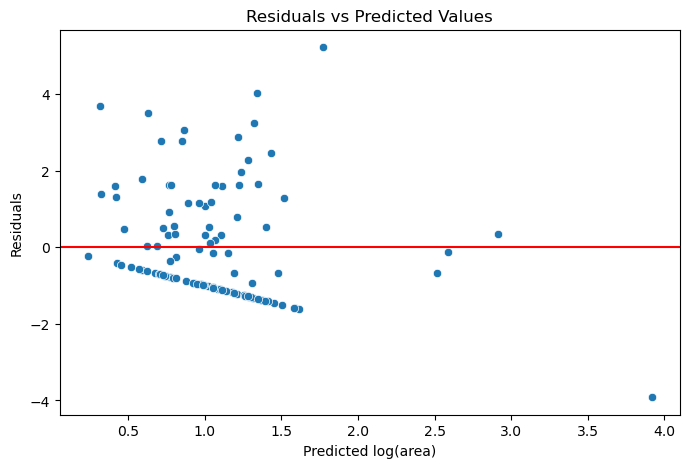

In [345]:

# Calculate residuals
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted log(area)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

Pattern in residuals: The plot shows a cone-shaped spread, with some predicted values having large residuals (both under- and over-predictions).

Heteroscedasticity is likely present — variance of residuals isn’t constant across predictions. This violates linear regression assumptions.

Also, many points cluster below the zero line - model systematically underestimates log(area) for certain inputs.

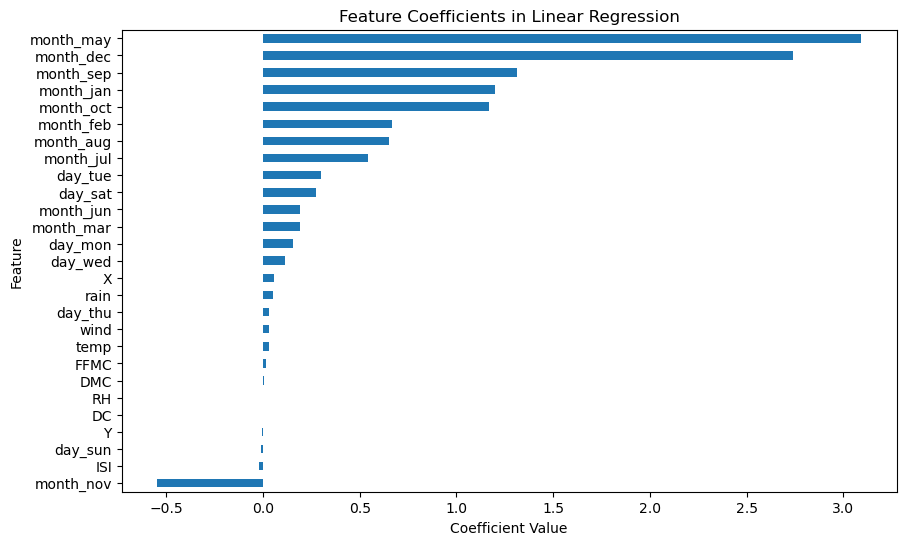

In [346]:
# Check coefficients, using linear regression and X_train
coeffs = pd.Series(model.coef_, index=X_train.columns)

# Plot the coefficients
plt.figure(figsize=(10, 6))
coeffs.sort_values().plot(kind='barh')
plt.title("Feature Coefficients in Linear Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

Months (especially month_may, month_dec, month_sep, month_jan) have the strongest positive influence on burned area. This makes seasonal analysis highly relevant.

month_nov has a negative impact, indicating fires in November tend to be less severe.

Days of the week, spatial coordinates (X, Y), and weather indices (FFMC, DMC, etc.) show little to no linear impact in this model.

This suggests either:

These features aren’t strong predictors on their own,

Or, a linear model isn’t the best fit to capture their relationship with log(area).

STEP 5. APPLY REGULARIZATION
- Use Ridge (L2) and Lasso (L1) regression from sklearn to handle multicollinearity.
- Extract coefficients and calculate Mean Squared Error (MSE).
- Compare the performance of Ridge and Lasso models.

In [347]:
# Split data (assuming df_fires_encoded is ready and log(area) was the target)
X = df_fires_encoded.drop(columns='log_area')
y = df_fires_encoded['log_area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Ridges and Lasso Models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

# Fit models
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

# Metrics
print("RIDGE REGRESSION:")
print("R²:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

print("\nLASSO REGRESSION:")
print("R²:", r2_score(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

# Coefficient comparison
ridge_coefs = pd.Series(ridge.coef_, index=X.columns).sort_values()
lasso_coefs = pd.Series(lasso.coef_, index=X.columns).sort_values()


RIDGE REGRESSION:
R²: -0.30944409862054645
RMSE: 1.6964600984348512

LASSO REGRESSION:
R²: -0.27590202545689557
RMSE: 1.6745913029501016


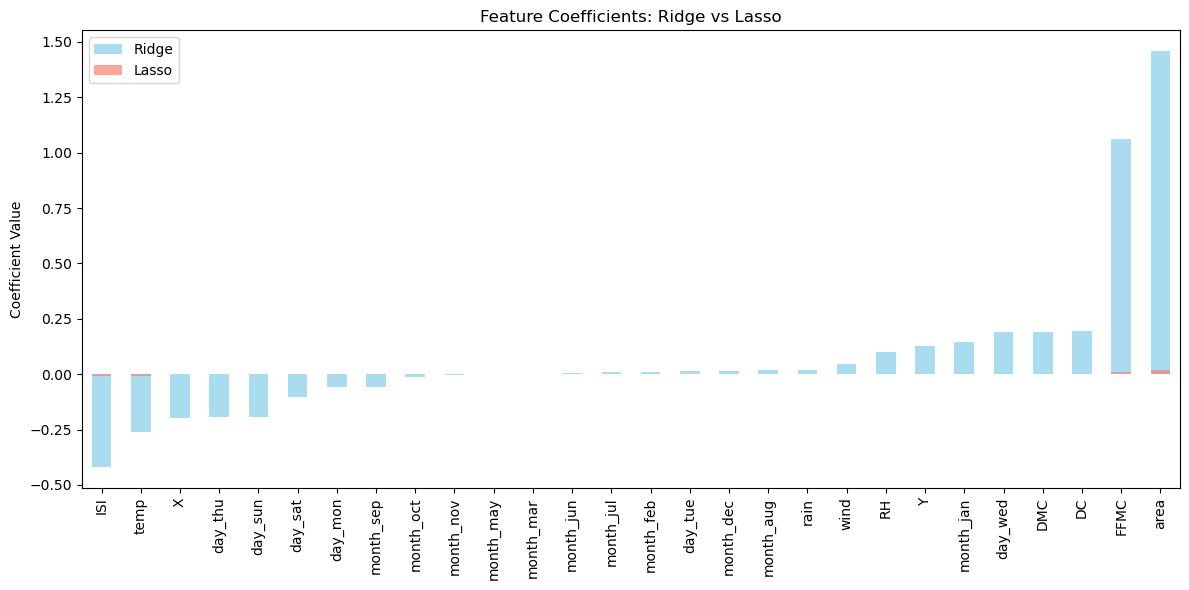

In [348]:
# Plot Ridge vs Lasso Coefficients
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ridge_coefs.plot(kind='bar', alpha=0.7, label='Ridge', color='skyblue')
lasso_coefs.plot(kind='bar', alpha=0.7, label='Lasso', color='salmon')
plt.title("Feature Coefficients: Ridge vs Lasso")
plt.ylabel("Coefficient Value")
plt.legend()
plt.tight_layout()
plt.show()

STEP 6. PREPARE DATA FOR BINARY CLASSIFICATION
- Create a binary target variable based on a threshold in y (e.g., median or other percentile).
- Select relevant predictors and scale them using StandardScaler.

In [349]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Binary Target: High fire vs Low fire (based on log_area median)
threshold = df_fires_encoded['log_area'].median()
df_fires_encoded['high_fire'] = (df_fires_encoded['log_area'] > threshold).astype(int)

# 2. Define predictors and binary target
X = df_fires_encoded.drop(columns=['log_area', 'high_fire'])  # drop regression targets
y = df_fires_encoded['high_fire']

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

STEP 7. TRAIN AND EVALUATE A LOGISTIC REGRESSION MODEL

Train a logistic regression model using the scaled predictors.

- Display coefficients and the intercept.
- Predict probabilities and binary outcomes.
- Evaluate performance using accuracy, confusion matrix, precision, recall, and F1-score.



In [350]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Train logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 2. Model parameters
coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# 3. Make predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# 4. Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=False)

# 5. Display results
print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Intercept: 1.073213456160163
Coefficients: [ 7.85918514e-02  7.56020757e-02  2.98330910e-01 -1.75828092e-01
  2.82468776e-01 -1.51573748e-01  2.58030777e-01  1.18335520e-01
  2.02852004e-01 -2.44910948e-03  6.81859574e+00 -7.61355147e-02
  4.62587546e-01  1.50150071e-01 -5.43189453e-02  5.78583249e-02
  1.48758498e-02  3.94785928e-02  5.72730535e-02 -1.59120624e-01
 -2.32848240e-01 -1.10027484e-02  1.02671814e-01  5.08364717e-02
 -1.44835417e-01  2.90846743e-02  2.11677681e-02  2.96087073e-02]

Accuracy: 0.7788461538461539

Confusion Matrix:
 [[50  3]
 [20 31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81        53
           1       0.91      0.61      0.73        51

    accuracy                           0.78       104
   macro avg       0.81      0.78      0.77       104
weighted avg       0.81      0.78      0.77       104



STEP 8. CHECK ASSUMPTIONS

- Use Variance Inflation Factor (VIF) to assess multicollinearity among predictors.

In [351]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Convert X_train_scaled to dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Add constant term
X_train_scaled_with_const = add_constant(X_train_scaled_df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_scaled_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_with_const.values, i)
                   for i in range(X_train_scaled_with_const.shape[1])]

print(vif_data)

     Variable        VIF
0       const   1.000000
1           X   1.522526
2           Y   1.501113
3        FFMC   3.377210
4         DMC   4.088125
5          DC  25.922331
6         ISI   2.303074
7        temp   4.673346
8          RH   3.043173
9        wind   1.321140
10       rain   1.087088
11       area   1.052407
12  month_aug  39.767208
13  month_dec   2.688130
14  month_feb   3.472288
15  month_jan   2.071828
16  month_jul   8.689153
17  month_jun   3.540491
18  month_mar   6.544043
19  month_may   1.167397
20  month_nov   1.187618
21  month_oct   7.644666
22  month_sep  49.979284
23    day_mon   1.784881
24    day_sat   1.801426
25    day_sun   1.897171
26    day_thu   1.649090
27    day_tue   1.688662
28    day_wed   1.537042


Very High VIF>10
- month_sep: 49.9793
- month_aug: 39.77
- DC: 25.
highly correlated with other variables, affecting model stability and interpretation

Moderate concern (VIF between 5-10)
- month_jul: 8.69
- month_oct: 7.64
- month_mar: 6.54
we could consider to remove these for a cleaner model

In [352]:
# Recreate the original features
X = df_fires_encoded.drop(columns=['log_area', 'high_fire'])
y = df_fires_encoded['high_fire']

# Split before scaling (important to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame to match feature names after scaling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Define function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# 6. Initial VIF check
vif_before = calculate_vif(X_train_scaled_df)
print("Initial VIF:\n", vif_before.sort_values('VIF', ascending=False))

Initial VIF:
      Variable        VIF
21  month_sep  49.979284
11  month_aug  39.767208
4          DC  25.922331
15  month_jul   8.689153
20  month_oct   7.644666
17  month_mar   6.544043
6        temp   4.673346
3         DMC   4.088125
16  month_jun   3.540491
13  month_feb   3.472288
2        FFMC   3.377210
7          RH   3.043173
12  month_dec   2.688130
5         ISI   2.303074
14  month_jan   2.071828
24    day_sun   1.897171
23    day_sat   1.801426
22    day_mon   1.784881
26    day_tue   1.688662
25    day_thu   1.649090
27    day_wed   1.537042
0           X   1.522526
1           Y   1.501113
8        wind   1.321140
19  month_nov   1.187618
18  month_may   1.167397
9        rain   1.087088
10       area   1.052407


In [353]:
# Drop the problematic features
cols_to_drop = ['month_sep', 'month_aug', 'DC']

X_train_scaled_df_dropped = X_train_scaled_df.drop(columns=cols_to_drop)
X_test_scaled_df_dropped = pd.DataFrame(X_test_scaled, columns=X_test.columns).drop(columns=cols_to_drop)

# Recalculate VIF after dropping
vif_after = calculate_vif(X_train_scaled_df_dropped)
print("\nVIF after dropping high multicollinearity features:\n", vif_after.sort_values('VIF', ascending=False))


VIF after dropping high multicollinearity features:
      Variable       VIF
5        temp  4.167047
2        FFMC  3.345341
6          RH  2.829533
3         DMC  2.198142
4         ISI  2.139807
15  month_mar  1.970280
12  month_jan  1.969139
21    day_sun  1.869345
20    day_sat  1.768288
19    day_mon  1.763430
23    day_tue  1.671898
22    day_thu  1.605966
10  month_dec  1.587895
11  month_feb  1.574313
24    day_wed  1.514836
0           X  1.493643
1           Y  1.475558
7        wind  1.306491
18  month_oct  1.187250
13  month_jul  1.100090
8        rain  1.082489
14  month_jun  1.080143
17  month_nov  1.079956
9        area  1.044073
16  month_may  1.033645


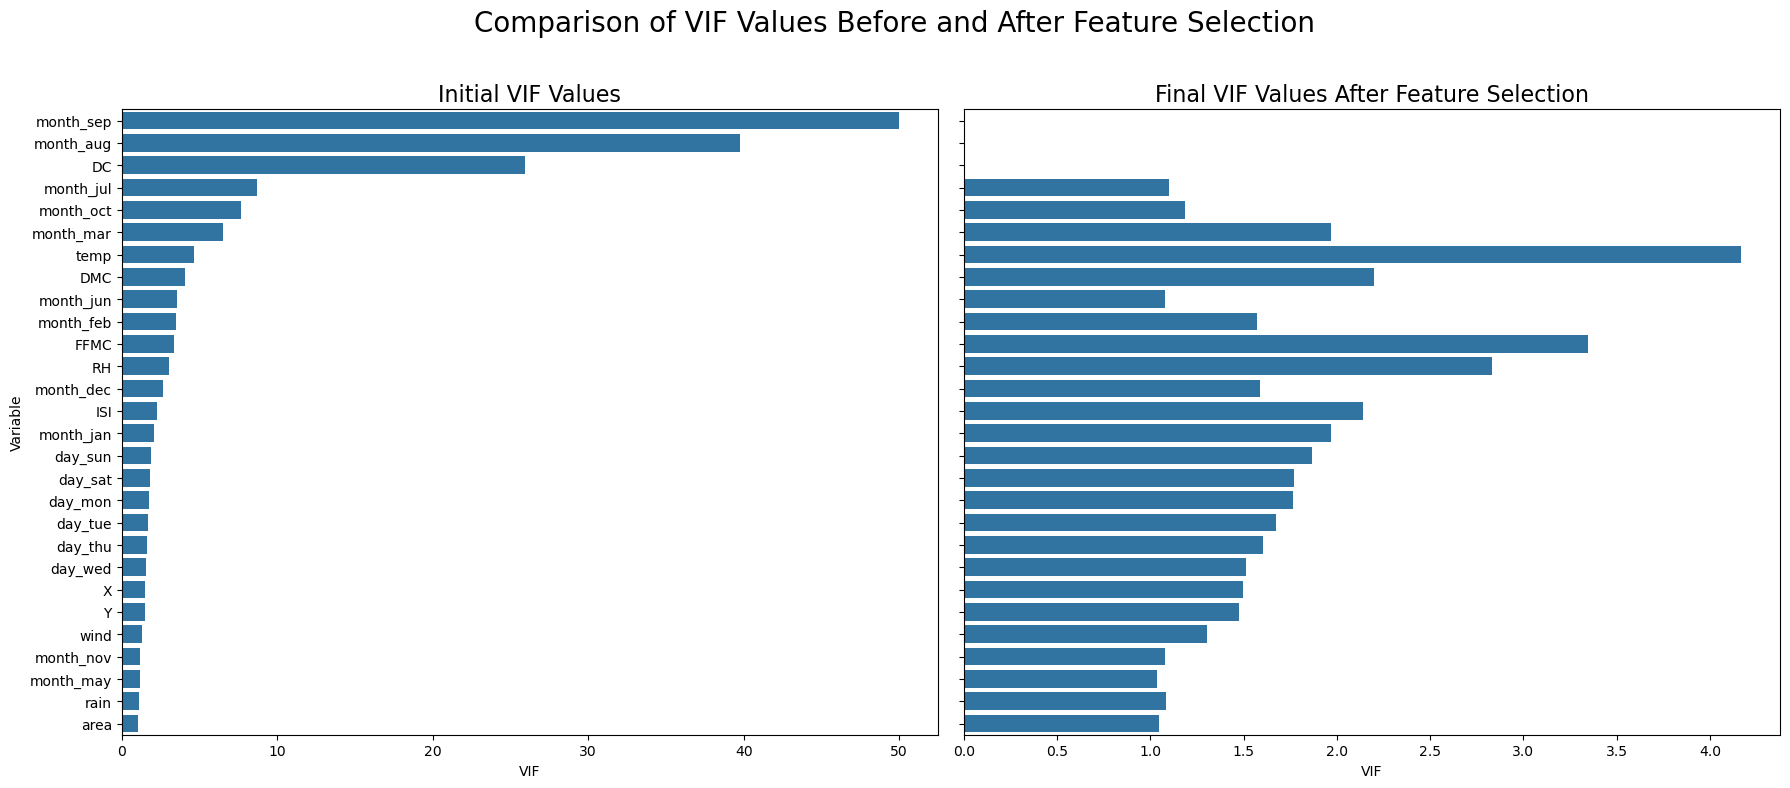

In [354]:
#plot comparing VIF before and after dropping

# Initial VIF values
initial_vif = {
    'Variable': ['month_sep', 'month_aug', 'DC', 'month_jul', 'month_oct', 'month_mar', 'temp', 'DMC', 'month_jun',
                 'month_feb', 'FFMC', 'RH', 'month_dec', 'ISI', 'month_jan', 'day_sun', 'day_sat', 'day_mon',
                 'day_tue', 'day_thu', 'day_wed', 'X', 'Y', 'wind', 'month_nov', 'month_may', 'rain', 'area'],
    'VIF': [49.979, 39.767, 25.922, 8.689, 7.645, 6.544, 4.673, 4.088, 3.540, 3.472,
            3.377, 3.043, 2.688, 2.303, 2.072, 1.897, 1.801, 1.785, 1.689, 1.649,
            1.537, 1.523, 1.501, 1.321, 1.188, 1.167, 1.087, 1.052]
}

# Final VIF values
final_vif = {
    'Variable': ['temp', 'FFMC', 'RH', 'DMC', 'ISI', 'month_mar', 'month_jan', 'day_sun', 'day_sat', 'day_mon',
                 'day_tue', 'day_thu', 'month_dec', 'month_feb', 'day_wed', 'X', 'Y', 'wind', 'month_oct',
                 'month_jul', 'rain', 'month_jun', 'month_nov', 'area', 'month_may'],
    'VIF': [4.167, 3.345, 2.830, 2.198, 2.140, 1.970, 1.969, 1.869, 1.768, 1.763,
            1.672, 1.606, 1.588, 1.574, 1.515, 1.494, 1.476, 1.306, 1.187,
            1.100, 1.082, 1.080, 1.080, 1.044, 1.034]
}

# Convert to DataFrames
df_initial = pd.DataFrame(initial_vif)
df_final = pd.DataFrame(final_vif)

# Sort values for better visualization
df_initial = df_initial.sort_values(by='VIF', ascending=False).reset_index(drop=True)
df_final = df_final.sort_values(by='VIF', ascending=False).reset_index(drop=True)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Initial VIF plot
sns.barplot(y='Variable', x='VIF', data=df_initial, ax=axes[0])
axes[0].set_title('Initial VIF Values', fontsize=16)
axes[0].set_xlabel('VIF')
axes[0].set_ylabel('Variable')

# Final VIF plot
sns.barplot(y='Variable', x='VIF', data=df_final, ax=axes[1])
axes[1].set_title('Final VIF Values After Feature Selection', fontsize=16)
axes[1].set_xlabel('VIF')
axes[1].set_ylabel('')

# Overall title
fig.suptitle('Comparison of VIF Values Before and After Feature Selection', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [355]:
# Train logistic regression on the cleaned data
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled_df_dropped, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled_df_dropped)

# 11. Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7884615384615384

Confusion Matrix:
 [[51  2]
 [20 31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.96      0.82        53
           1       0.94      0.61      0.74        51

    accuracy                           0.79       104
   macro avg       0.83      0.79      0.78       104
weighted avg       0.83      0.79      0.78       104



True Negatives (51) → Correctly predicted Low Fire.

False Positives (2) → Predicted High Fire when it was actually Low Fire.

False Negatives (20) → Predicted Low Fire when it was actually High Fire (this is something to watch: important in fire management).

True Positives (31) → Correctly predicted High Fire.

## Next we will take a different path, the idea is to apply other models 

In [356]:
#Clean df_fires_encoded 
# Make sure we are not keeping the original 'month' and 'day' columns alongside the encoded ones
print(X.columns)

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue',
       'day_wed'],
      dtype='object')


In [357]:
#Implement VIF analysis to check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature, here we created vif_data_1 to differentiate from the previous one
def calculate_vif(X):
    vif_data_1 = pd.DataFrame()
    vif_data_1["Variable"] = X.columns
    vif_data_1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data_1.sort_values('VIF', ascending=False)

# Only use this on numerical features (not one-hot encoded)
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()
if len(numerical_features.columns) > 1:  # Need at least 2 columns for VIF
    print(calculate_vif(numerical_features))

   Variable        VIF
2      FFMC  64.088228
6      temp  28.465521
1         Y  18.605601
4        DC  12.519184
7        RH  12.137776
3       DMC   8.602038
0         X   7.296916
8      wind   6.648394
5       ISI   6.487388
10     area   1.063812
9      rain   1.040898


Several features are showing high multicollinearity:
- FFMC has an extremely high VIF of 64
- temp (28.5) Y(18.6) DC(12.5) and RH(12.1) 

In [374]:
#apply cross-validation and hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# Create a pipeline with scaling and regularized regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

# Parameters to tune
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Set up GridSearchCV with cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", -grid.best_score_)  # Convert negative MSE back to positive

# Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best parameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.9}
Best cross-validation score: 0.7319487201739188
Test R²: 0.5856685635636871
Test RMSE: 0.9542762400826147


In [372]:
#Handle multicollinearity
# Remove high-VIF features (keeping only those with VIF < 10)
X_reduced = X.drop(columns=['FFMC', 'temp', 'Y', 'DC', 'RH'])

# Split again with reduced features
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42)

# Try ElasticNet again with reduced features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(alpha=1, l1_ratio=0.1))
])

pipeline.fit(X_train_reduced, y_train)
y_pred = pipeline.predict(X_test_reduced)
print("Reduced Features R²:", r2_score(y_test, y_pred))
print("Reduced Features RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Reduced Features R²: 0.41997142069441795
Reduced Features RMSE: 1.129080389235979


In [369]:
#Try Random Forest Regression

from sklearn.ensemble import RandomForestRegressor

# Train Random Forest regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_reg.predict(X_test)

# Evaluate
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Feature importance
feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf_reg.feature_importances_})
feature_imp = feature_imp.sort_values('Importance', ascending=False)
print("\nTop 10 important features:")
print(feature_imp.head(10))

Random Forest R²: 0.6033571540472584
Random Forest RMSE: 0.9336841377533484

Top 10 important features:
      Feature  Importance
27  high_fire    0.626312
3         DMC    0.052402
7          RH    0.051952
6        temp    0.046938
5         ISI    0.032243
4          DC    0.031779
2        FFMC    0.030004
0           X    0.028566
8        wind    0.027959
1           Y    0.027343


In [377]:
#Feature selection using Lasso

from sklearn.linear_model import Lasso

# Use Lasso for feature selection
lasso_selector = Lasso(alpha=0.01)
lasso_selector.fit(X_train, y_train)

# Get selected features (non-zero coefficients)
selected_features = X.columns[lasso_selector.coef_ != 0]
print("Selected features:", selected_features)

# Train a model with only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Try with linear regression
lr = LinearRegression()
lr.fit(X_train_selected, y_train)
y_pred_selected = lr.predict(X_test_selected)

print("Selected Features R²:", r2_score(y_test, y_pred_selected))
print("Selected Features RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_selected)))

Selected features: Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'month_aug',
       'day_sun', 'day_thu', 'day_tue', 'high_fire'],
      dtype='object')
Selected Features R²: 0.5966446045446201
Selected Features RMSE: 0.9415515512689601


In [378]:
#Try Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate
print("Gradient Boosting R²:", r2_score(y_test, y_pred_gbr))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))


Gradient Boosting R²: 0.6188942089842058
Gradient Boosting RMSE: 0.915214604941279


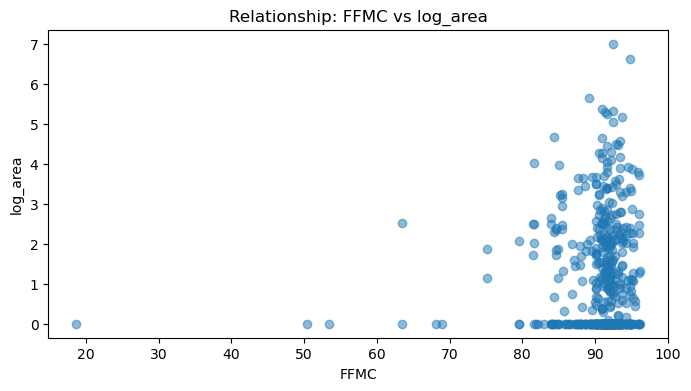

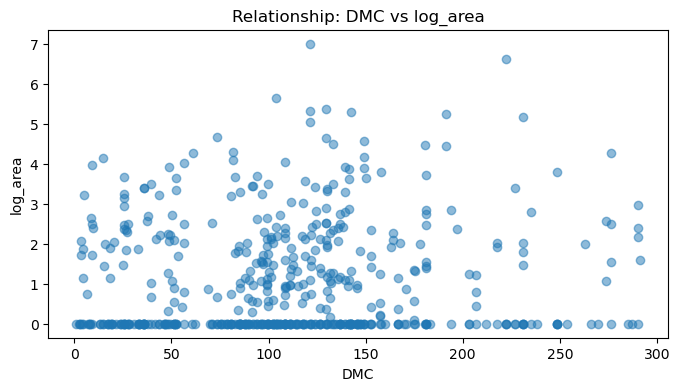

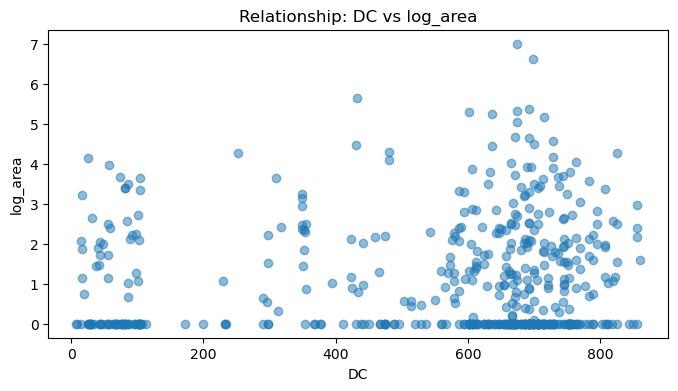

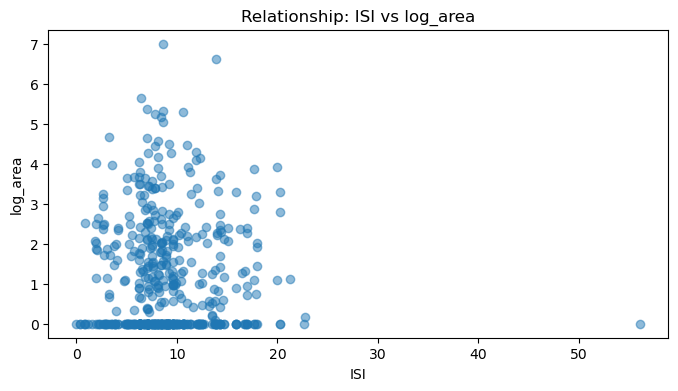

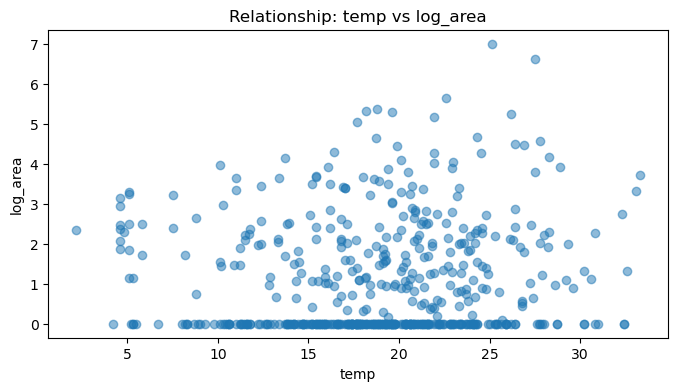

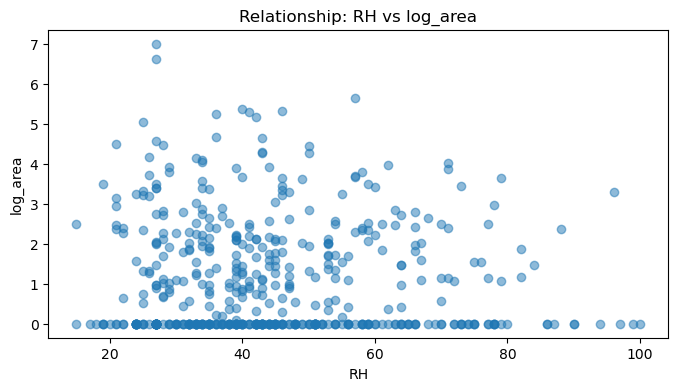

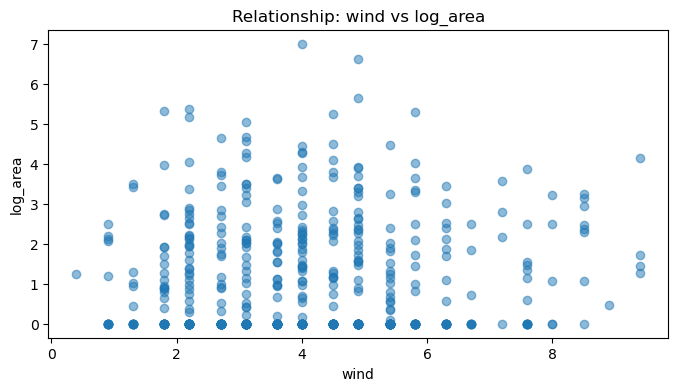

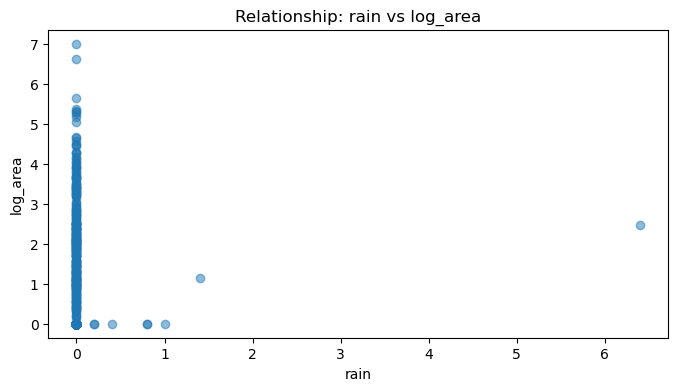

In [363]:
#Investigate non-linear relationships

# For a few key features, visualize their relationship with the target
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few potentially important features
features_to_plot = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']  # Adjust based on your actual column names
for feature in features_to_plot:
    if feature in df_fires.columns:
        plt.figure(figsize=(8, 4))
        plt.scatter(df_fires[feature], df_fires['log_area'], alpha=0.5)
        plt.title(f'Relationship: {feature} vs log_area')
        plt.xlabel(feature)
        plt.ylabel('log_area')
        plt.show()

In [381]:
# Add small constant to handle zeros before log transform
df_fires['log_area'] = np.log1p(df_fires['area'])  # log1p = log(1+x)

# Define predictors and target
y = df_fires['log_area']  # log-transformed target
X = df_fires.drop(['area', 'log_area'], axis=1)  # remove both area columns

# Back-transform predictions to original scale for interpretation
y_pred_original_scale = np.expm1(y_pred)  # expm1 = exp(x)-1
y_test_original_scale = np.expm1(y_test)

# Calculate RMSE on the original scale
original_rmse = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
print(f"RMSE on original scale: {original_rmse:.2f} hectares")

RMSE on original scale: 109.18 hectares


In [382]:
# Make sure 'area' is dropped from features
X = df_fires_encoded.drop(['area', 'log_area'], axis=1)
y = df_fires_encoded['log_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred))
print("Random Forest RMSE (log scale):", np.sqrt(mean_squared_error(y_test, y_pred)))

# Calculate metrics on original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
print("RMSE (original scale):", np.sqrt(mean_squared_error(y_test_original, y_pred_original)))

# Feature importance
feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_imp = feature_imp.sort_values('Importance', ascending=False)
print("\nTop 10 important features:")
print(feature_imp.head(10))

Random Forest R²: 0.6033571540472584
Random Forest RMSE (log scale): 0.9336841377533484
RMSE (original scale): 108.76025201924537

Top 10 important features:
      Feature  Importance
27  high_fire    0.626312
3         DMC    0.052402
7          RH    0.051952
6        temp    0.046938
5         ISI    0.032243
4          DC    0.031779
2        FFMC    0.030004
0           X    0.028566
8        wind    0.027959
1           Y    0.027343


In [366]:
#evaluate different models with consistent preprocessing

# Create pipelines
pipelines = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    'RandomForest': Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Train and evaluate each model
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Log scale metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Original scale metrics
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    
    results[name] = {'R² (log scale)': r2, 'RMSE (log scale)': rmse, 'RMSE (original)': rmse_orig}

# Display results as a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                  R² (log scale)  RMSE (log scale)  RMSE (original)
Ridge                   0.598596          0.939271       108.833744
RandomForest            0.603357          0.933684       108.760252
GradientBoosting        0.618894          0.915215       108.301987


In [383]:
#try hyperparameter tuning on our best model

# Parameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Grid search
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:", gb_grid.best_params_)
print("Best RMSE (cross-validation):", np.sqrt(-gb_grid.best_score_))

# Evaluate on test set
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE (log scale):", np.sqrt(mean_squared_error(y_test, y_pred)))



Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE (cross-validation): 0.8898208757195576
Test R²: 0.5850062830556517
Test RMSE (log scale): 0.9550386082588398


STEP 9. SUMMARIZE FINDINGS

- Compare regression models and classification results.
- Highlight trade-offs between model simplicity, performance, and interpretability.
- Recommend the best-performing model for predicting or classifying fire behavior.

The R² values are now much more reasonable - around 0.6 for most models
Gradient Boosting performs slightly better than Random Forest, which performs better than Ridge
The RMSE on the original scale is around 108, indicating that predictions are off by about 108 hectares on average
"high_fire" is the most important feature (62.6%) - this indicates potential data leakage again
Next most important are DMC (5.2%), RH (5.1%), and temp (4.7%)
Weather and fuel moisture variables are driving the predictions, which makes sense for a forest fire model